In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import time
from segment_anything import sam_model_registry, SamPredictor
from torchvision.ops import masks_to_boxes

In [2]:

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

product_data_dir = "../data/product_detection_from_packshots/product_images"
prodcut_images_path_list = [f"{product_data_dir}/{file}" for file in os.listdir(product_data_dir)]
# for i in range(1,301):
#     path = f"{product_data_dir}/qr{i}.jpg"
#     if not os.path.exists(path):
        
#         print(f"path not found: {path}")
#     else:
#         prodcut_images_path_list.append(path)


## Example image

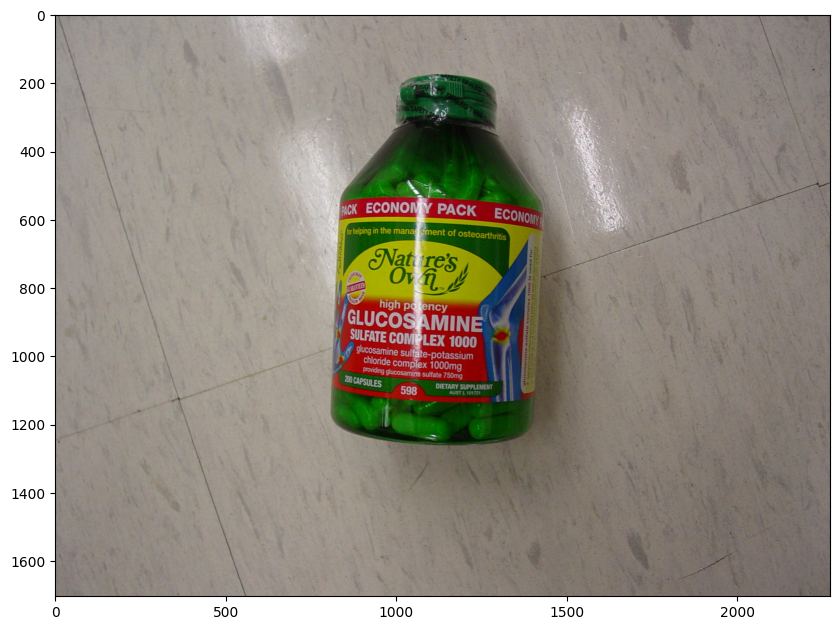

In [16]:
image = cv2.imread(prodcut_images_path_list[3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

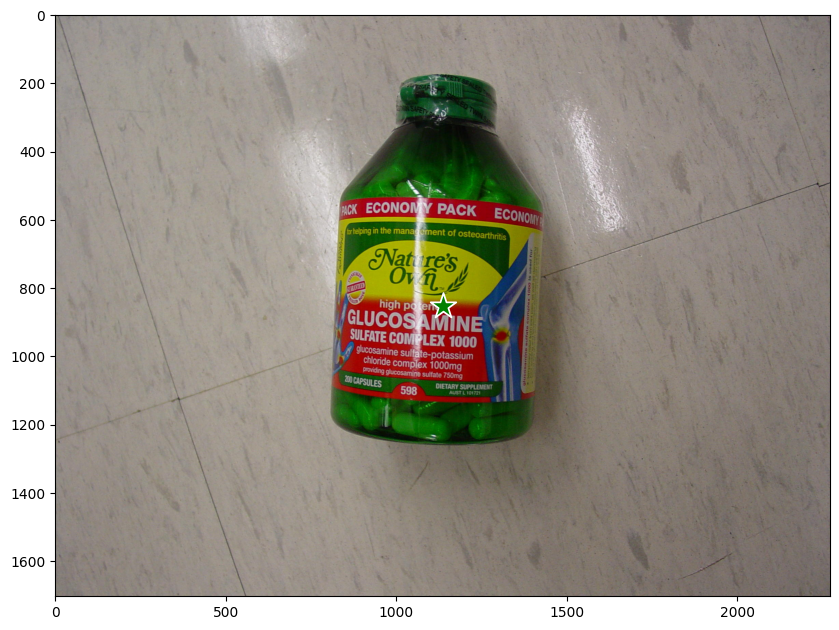

In [15]:
predictor.set_image(image)
input_point = np.array([[image.shape[1]//2, image.shape[0]//2]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

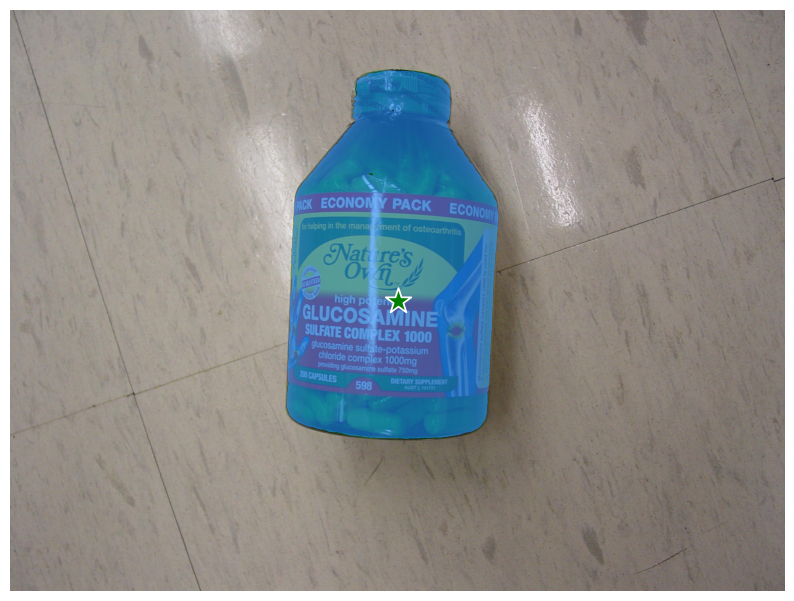

In [17]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[masks.shape[0]-1], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

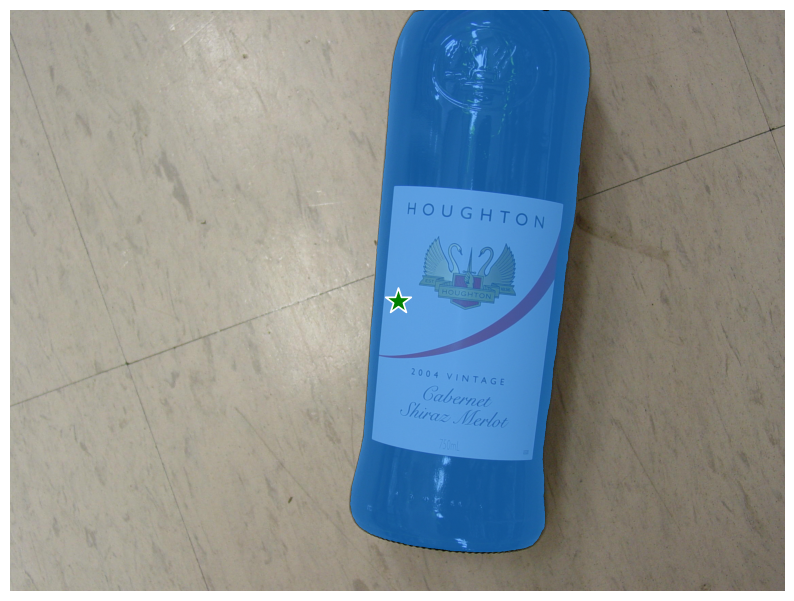

In [13]:
masks.shape  # (number_of_masks) x H x W
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[masks.shape[0]], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

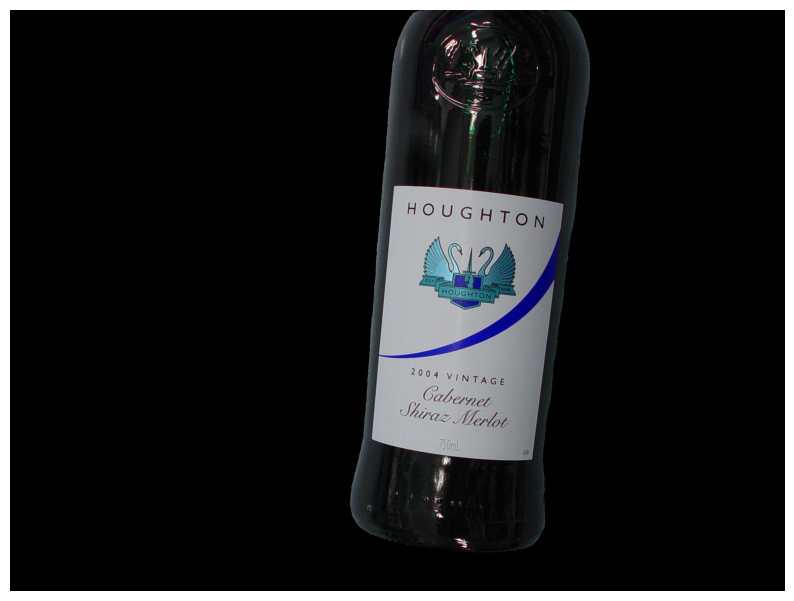

In [11]:
input_label = np.array([1])
def crop():
    path = prodcut_images_path_list[0]
    image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_point = np.array([[image.shape[1]//2, image.shape[0]//2]])
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    mask = masks[masks.shape[0]-1]
    #print(type(mask), mask.shape)
    mask3d = np.dstack([mask]*3)
    cut_out_mask = np.invert(mask3d)
    cutout_image = np.where(cut_out_mask, 0, image)
    

    plt.figure(figsize=(10,10))
    plt.imshow(cutout_image)
    plt.axis('off')
    plt.show()
crop()

In [12]:
input_label = np.array([1])
def dump_product_cropped_mask_image():
    dump_dir = f"../data/product_detection_from_packshots/product_mask_images"
    total = len(prodcut_images_path_list)
    counter = 1
    for path in prodcut_images_path_list:
        start_time = time.time()
        file_name = path.split("/")[-1]
        
        image = cv2.imread(path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_point = np.array([[image.shape[1]//2, image.shape[0]//2]])
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
        mask = masks[masks.shape[0]-1]
        #print(type(mask), mask.shape)
        mask3d = np.dstack([mask]*3)
        cut_out_mask = np.invert(mask3d)
        cutout_image = np.where(cut_out_mask, 0, image)
        cv2.imwrite(f"{dump_dir}/{file_name}", cutout_image)
        end_time = time.time()
        print(f"Processed: [{counter}/{total}] {file_name} | Time: {end_time-start_time}")
        counter+=1
    

    
dump_product_cropped_mask_image()

Processed: [1/300] qr1.jpg | Time: 1.2075409889221191
Processed: [2/300] qr10.jpg | Time: 0.9722170829772949
Processed: [3/300] qr100.jpg | Time: 0.984473466873169
Processed: [4/300] qr101.jpg | Time: 1.0097737312316895
Processed: [5/300] qr102.jpg | Time: 0.9893174171447754
Processed: [6/300] qr103.jpg | Time: 0.9919462203979492
Processed: [7/300] qr104.jpg | Time: 0.9928905963897705
Processed: [8/300] qr105.jpg | Time: 0.9959583282470703
Processed: [9/300] qr106.jpg | Time: 0.9569356441497803
Processed: [10/300] qr107.jpg | Time: 0.9543709754943848
Processed: [11/300] qr108.jpg | Time: 0.9388537406921387
Processed: [12/300] qr109.jpg | Time: 0.9549117088317871
Processed: [13/300] qr11.jpg | Time: 0.9482998847961426
Processed: [14/300] qr110.jpg | Time: 0.9498188495635986
Processed: [15/300] qr111.jpg | Time: 0.9533894062042236
Processed: [16/300] qr112.jpg | Time: 0.9988934993743896
Processed: [17/300] qr113.jpg | Time: 1.006091594696045
Processed: [18/300] qr114.jpg | Time: 0.998917

In [ ]:
mask